### Environment

In [1]:
import sys
import os

# プロジェクトルートをsys.pathに追加
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH set to:", project_root)

PYTHONPATH set to: c:\Users\ndhaj\Desktop\TCI


### Load data

In [2]:
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")

from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.rng_utils import normal, get_rng

ptycho = Ptycho()
obj = load_data_image("cameraman.png") * np().exp(1j * np().pi * load_data_image("eagle.png"))
rng = get_rng(seed = 50)

from PtychoEP.utils.ptycho.aperture_utils import circular_aperture
probe = circular_aperture(size = 64, r = 0.48)

ptycho.set_object(obj)
ptycho.set_probe(probe)

### Scan position

In [3]:
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions

positions = generate_spiral_scan_positions(image_size=512, probe_size=64, step = 22, num_points=400)
print(f"Generated {len(positions)} scan positions")

Generated 132 scan positions


### forward calculation

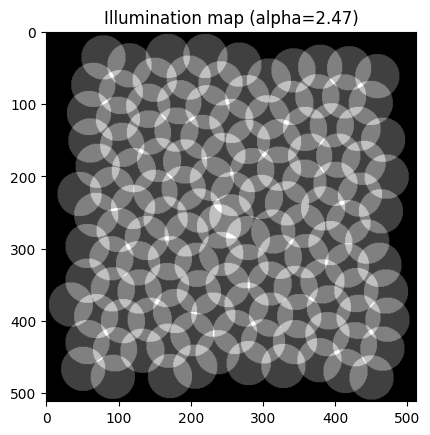

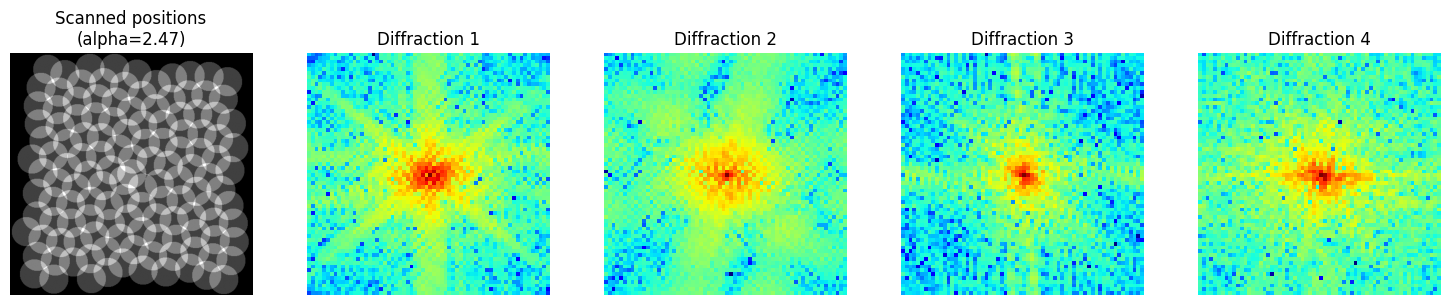

In [4]:
ptycho.forward_and_set_diffraction(positions)

from PtychoEP.utils.ptycho.visualize import compute_illumination, show_scan_and_diffs
scan_img, alpha = compute_illumination(ptycho)

import matplotlib.pyplot as plt
plt.imshow(scan_img, cmap="gray")
plt.title(f"Illumination map (alpha={alpha:.2f})")
plt.show()

fig = show_scan_and_diffs(ptycho, num_patterns=4, log_scale=True)

In [5]:
from PtychoEP.utils.ptycho.noise import GaussianNoise, PoissonNoise

GaussianNoise(var=1e-5) @ ptycho
print("Gaussian noise SNR [dB]:", ptycho.noise_stats["snr_mean_db"])

Gaussian noise SNR [dB]: 41.00896072387695


### PIE

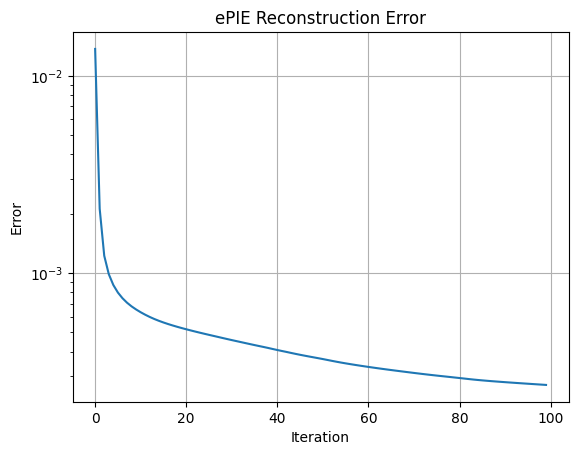

In [6]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.pie import PIE
from PtychoEP.utils.ptycho.noise import GaussianNoise
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=100, step = 10)
ptycho.forward_and_set_diffraction(positions)

#nosie付加
GaussianNoise(var = 1e-4) @ ptycho

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_true)

# --- ePIE 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

epie = PIE(ptycho, alpha=0.1, callback=callback)
obj_est = epie.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.yscale('log')
plt.title("ePIE Reconstruction Error")
plt.grid()
plt.show()

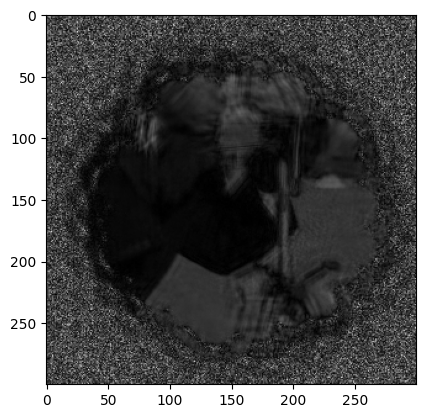

In [7]:
plt.imshow(np().abs(obj_est[100:400,100:400]), cmap = "gray")

### PtychoEP

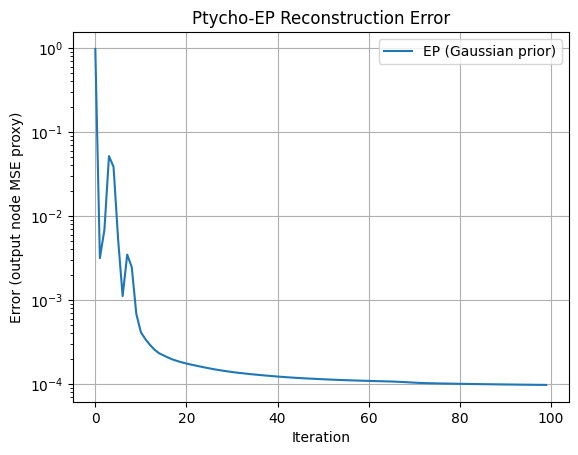

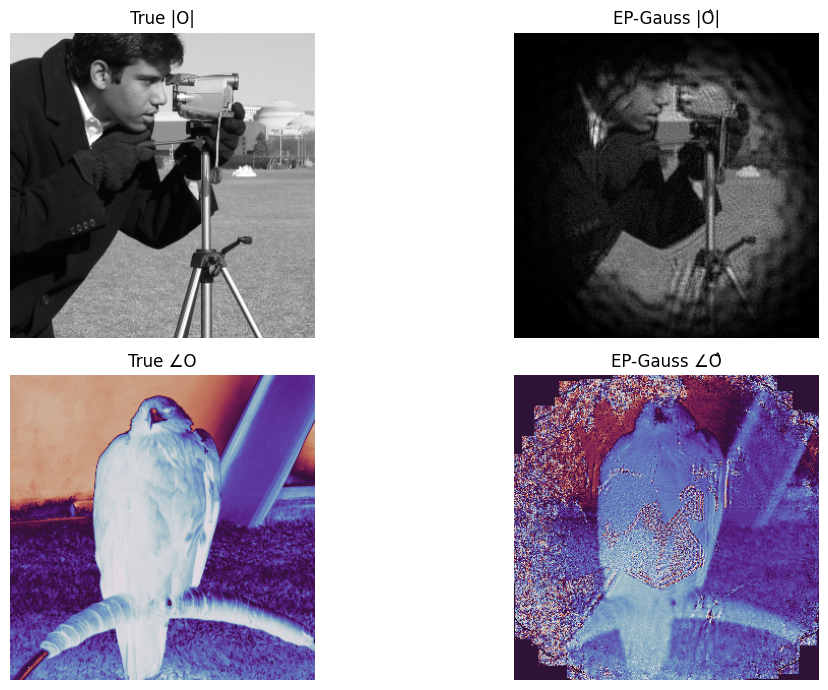

In [14]:
# ===== Backend設定 =====
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")   # GPUを使うなら "cupy"

# ===== 必要モジュール =====
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.ptycho_ep.core import PtychoEP
from PtychoEP.utils.ptycho.noise import GaussianNoise
import matplotlib.pyplot as plt

# ===== データ準備 =====
ptycho = Ptycho()

# 位相オブジェクト（PIEデモと同じ）
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype=np().complex64)
ptycho.set_object(obj)

# プローブ（真値でforward → そのまま初期値にも使用）
probe_true = np().asarray(load_data_image("probe.png"), dtype=np().complex64)
ptycho.set_probe(probe_true)

# スキャン座標とforward
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=100, step=10)
ptycho.forward_and_set_diffraction(positions)

#nosie付加
GaussianNoise(var = 1e-4) @ ptycho

# ===== Ptycho-EP（Gaussian prior: prior更新なし）=====
errors_gauss = []
def cb_gauss(it, err, obj_est):
    errors_gauss.append(err)

solver_gauss = PtychoEP(
    ptycho,
    prior_type="gaussian",     # ← AUA初期状態が平均0・精度1のガウスに相当するのでprior更新はスキップ
    damping=0.5,
    callback=cb_gauss
)
obj_est_gauss, prb_est_gauss = solver_gauss.run(n_iter=100)

# ===== 誤差推移の可視化 =====
plt.plot(errors_gauss, label="EP (Gaussian prior)")
plt.xlabel("Iteration")
plt.ylabel("Error (output node MSE proxy)")
plt.yscale('log')
plt.title("Ptycho-EP Reconstruction Error")
plt.grid(True)
plt.legend()
plt.show()

# （任意）再構成結果の振幅/位相をざっと確認
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].imshow(np().abs(obj[100:400,100:400]), cmap="gray");              axes[0,0].set_title("True |O|"); axes[0,0].axis("off")
axes[1,0].imshow(np().angle(obj[100:400,100:400]), cmap="twilight");        axes[1,0].set_title("True ∠O"); axes[1,0].axis("off")

axes[0,1].imshow(np().abs(obj_est_gauss[100:400,100:400]), cmap="gray");    axes[0,1].set_title("EP-Gauss |Ô|"); axes[0,1].axis("off")
axes[1,1].imshow(np().angle(obj_est_gauss[100:400,100:400]), cmap="twilight"); axes[1,1].set_title("EP-Gauss ∠Ô"); axes[1,1].axis("off")

plt.tight_layout()
plt.show()

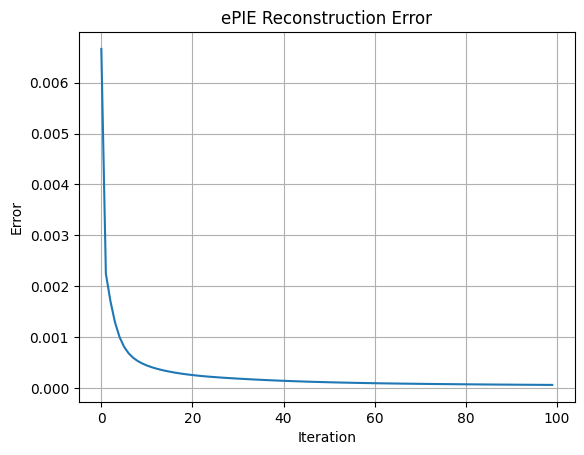

In [9]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.epie import ePIE
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)              # 真のプローブ
probe_init = np().asarray(load_data_image("probe_init.png"), dtype = np().complex64)          # 初期推定用プローブ

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=200, step = 5)
ptycho.forward_and_set_diffraction(positions)

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_init)

# --- ePIE 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

epie = ePIE(ptycho, alpha=0.1, beta=0.1, callback=callback)
obj_est, prb_est = epie.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("ePIE Reconstruction Error")
plt.grid()
plt.show()

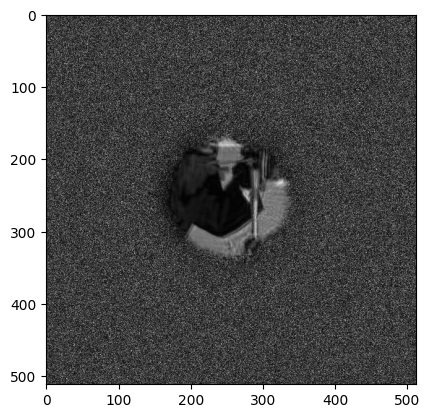

In [10]:
plt.imshow(np().abs(obj_est), cmap = "gray")

In [11]:
%prun epie.run(n_iter=100)

         2040304 function calls in 12.229 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    80000    5.760    0.000    5.797    0.000 _pocketfft.py:51(_raw_fft)
    20000    2.364    0.000    2.549    0.000 epie.py:9(_update_object)
    20000    1.287    0.000    1.527    0.000 epie.py:17(_update_probe)
    20000    1.233    0.000    7.858    0.000 projector.py:3(Fourier_projector)
        1    0.295    0.295   12.229   12.229 epie.py:26(run)
    60000    0.211    0.000    0.211    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    40000    0.208    0.000    0.208    0.000 {method 'conj' of 'numpy.ndarray' objects}
    40000    0.122    0.000    6.321    0.000 _pocketfft.py:735(_raw_fftnd)
    40000    0.119    0.000    0.332    0.000 _pocketfft.py:698(_cook_nd_args)
    20000    0.096    0.000    0.251    0.000 _methods.py:118(_mean)
    40000    0.064    0.000    0.119    0.000 fromnumeric.py:41(_wrapit)
    40000    

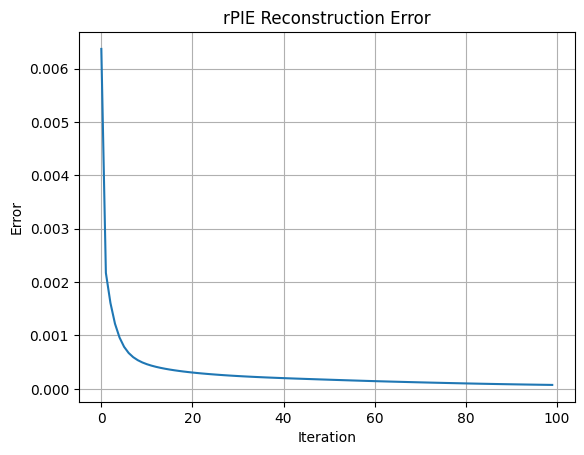

In [12]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.rpie import rPIE
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)              # 真のプローブ
probe_init = np().asarray(load_data_image("probe_init.png"), dtype = np().complex64)          # 初期推定用プローブ

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=200, step = 5)
ptycho.forward_and_set_diffraction(positions)

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_init)

# --- rPIE 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

rpie = rPIE(ptycho, alpha=0.1, beta=0.1, callback=callback)
obj_est, prb_est = rpie.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("rPIE Reconstruction Error")
plt.grid()
plt.show()

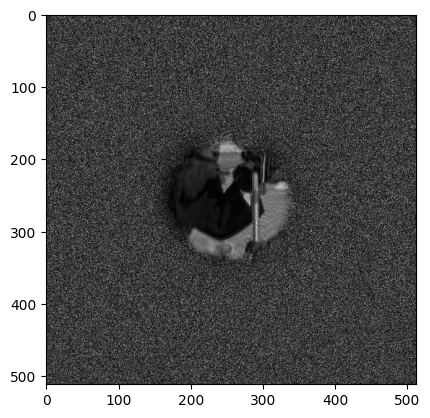

In [13]:
plt.imshow(np().abs(obj_est), cmap = "gray")

In [14]:
%prun rpie.run(n_iter=100)

         2040304 function calls in 12.607 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    80000    5.618    0.000    5.655    0.000 _pocketfft.py:51(_raw_fft)
    20000    2.357    0.000    2.552    0.000 rpie.py:9(_update_object)
    20000    1.525    0.000    1.778    0.000 rpie.py:18(_update_probe)
    20000    1.394    0.000    7.887    0.000 projector.py:3(Fourier_projector)
        1    0.389    0.389   12.607   12.607 rpie.py:28(run)
    40000    0.234    0.000    0.234    0.000 {method 'conj' of 'numpy.ndarray' objects}
    60000    0.206    0.000    0.206    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    40000    0.137    0.000    6.191    0.000 _pocketfft.py:735(_raw_fftnd)
    40000    0.122    0.000    0.331    0.000 _pocketfft.py:698(_cook_nd_args)
    20000    0.095    0.000    0.248    0.000 _methods.py:118(_mean)
    40000    0.063    0.000    0.116    0.000 fromnumeric.py:41(_wrapit)
    40000    

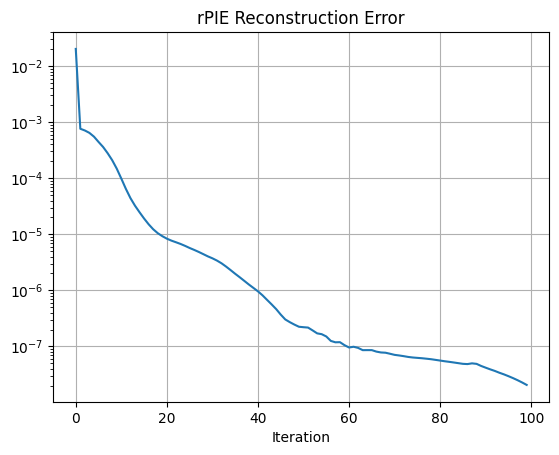

In [15]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.difference_map import DifferenceMap
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)              # 真のプローブ
probe_init = np().asarray(load_data_image("probe_init.png"), dtype = np().complex64)          # 初期推定用プローブ

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=200, step = 5)
ptycho.forward_and_set_diffraction(positions)

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_init)

# --- DM 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

dm = DifferenceMap(ptycho, callback=callback)
obj_est, prb_est = dm.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.yscale("log")
plt.title("rPIE Reconstruction Error")
plt.grid()
plt.show()

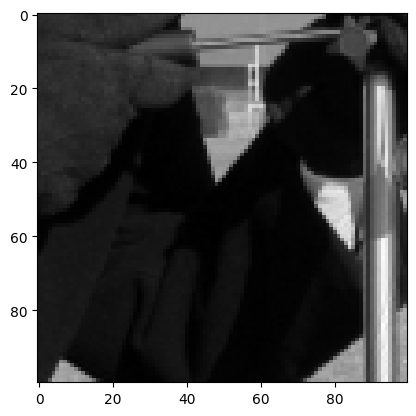

In [17]:
plt.imshow(np().abs(obj_est[200:300, 200:300]), cmap = "gray")